In [12]:
from utils import *

In [23]:
class AG:
    
    def __init__(self, nombre,persons,
                 individuals,mode_initial_pop,
                 n_generations,
                 p_crossover,
                 p_mutation=None,
                 crossover_func=ruleta,
                 generacional=False,
                 fitness_func=fitness_basic):
        self.nombre=nombre
        self.persons = persons
        self.gens = int(persons*(persons-1)/2)
        if individuals % 2 == 1:
            individuals+=1
        self.individuals=individuals
        self.current_population=None
        self.mode_initial_pop=mode_initial_pop
        self.fitness_func=fitness_func
        self.fitness={}
        self.n_generations=n_generations
        self.current_generation=1
        self.generations={1:{}}
        self.p_crossover=p_crossover
        if not p_mutation:
            p_mutation=1.0/self.gens
        self.p_mutation=p_mutation
        self.crossover_func=crossover_func
        self.generacional=generacional
        
    def generate_pop_ini(self):
        self.mode_initial_pop(self)
        
    def validate_grade_individual(self,individual):
        n=self.persons
        X=convert_individual_to_graph(n,individual)
        return sum(dict(nx.degree(X)).values())/n
        
    def show_dist_deggre_pop(self,size=(12,5),save=None):
        D=list(map(self.validate_grade_individual,self.current_population))
        fig = plt.figure()
        fig.set_size_inches(size[0], size[1])
        ax1 = fig.add_subplot(121)
        ax1.set_title("Distribution")
        ax2 = fig.add_subplot(122)
        ax2.set_title("Points")
        ax1.set_xlabel("Average Degree")
        ax1.set_ylabel("Frequency")
        ax2.set_xlabel("Average Degree")
        sns.distplot(D,kde=False,ax=ax1)
        sns.swarmplot(x=D,ax=ax2)
        
        if save:
            plt.savefig(save,dpi=300)
            
           
    def evaluate_fitness_ind(self,individual):
        t_f=t_form(individual)
        
        if t_f not in self.fitness:
            return self.fitness_func(individual)            
        else:
            return self.fitness[t_f]
            
    def evaluate_pop(self,P,offspring=None):
        values=list(map(self.evaluate_fitness_ind,P))
        for i,v in zip(P,values):
            self.fitness[t_form(i)]=v
        
        if not offspring:
            self.generations[self.current_generation]={"Average Fitness":np.mean(values),
                                                       "Best Individual":P[np.argmax(values)],
                                                       "Fitness Best":np.max(values)
            }
            
            return np.array(values),self.generations[self.current_generation] 
        else:
            return values
    
    def get_parents(self):
        
        return self.crossover_func(self.current_population,self.evaluate_pop(self.current_population)[0])
    
    def get_children(self,parents):
        
        def sub_process(P1,P2):
            linea_cruce=(np.random.randint(self.gens,size=len(P1))*(np.random.rand(len(P1)) < self.p_crossover)).reshape(len(P1),1)
            cruce=np.arange(self.gens)*np.ones_like(P1) >= linea_cruce
            H1=P1*(~cruce)+ P2*(cruce)

            muta1=(np.random.rand(H1.size).reshape(H1.shape) < self.p_mutation)*linea_cruce.astype(bool)
            H1=(H1+muta1)%2
            H2=P1*(cruce)+ P2*(~cruce)
            muta2=(np.random.rand(H2.size).reshape(H2.shape) < self.p_mutation)*linea_cruce.astype(bool)
            H2=(H2+muta2)%2
            
            return H1, H2
            
            
        P1=parents[::2]
        P2=parents[1::2]
        H1,H2 = sub_process(P1,P2)
        V1=pd.Series([validate_individual(self.persons,i) for i in H1])
        V2=pd.Series([validate_individual(self.persons,i) for i in H2])
        index=np.arange(self.individuals/2)[~(V1 & V2)].astype(int)
        
        while len(index) > 0:
            P1=parents[index*2]
            P2=parents[index*2+1]
            aux=sub_process(P1,P2)
            H1[index]=aux[0]
            H2[index]=aux[1]
            V1=pd.Series([validate_individual(self.persons,i) for i in H1])
            V2=pd.Series([validate_individual(self.persons,i) for i in H2])
            index=np.arange(self.individuals/2)[~(V1 & V2)].astype(int)           
        

        return H1, H2
    
    def evolution(self):
        PA=self.get_parents()
        P1=PA[::2]
        P2=PA[1::2]
        H1,H2 = self.get_children(PA)
        
        if self.generacional == False:
            H1_values=AG_1.evaluate_pop(H1,offspring=True)
            H2_values=AG_1.evaluate_pop(H2,offspring=True)
            PA_values=AG_1.evaluate_pop(PA,offspring=True)
            P1_values=PA_values[::2]
            P2_values=PA_values[1::2]

            A=np.array([H1,H2,P1,P2])
            values=np.array([H1_values,H2_values,P1_values,P2_values]).T
            L = np.argsort(-values, axis=1)
            best=L[:,:2]
            K=[]
            for i in range(len(best)):
                K.append(pd.DataFrame(A[best[i],i]))
            self.current_population = pd.concat(K).values
        else:
            self.current_population = np.concatenate((H1,H2))                    
        self.current_generation+=1
        return self.evaluate_pop(self.current_population)[1]   
    
    def plot_results(self,size=(12,5),save=None):
        fig = plt.figure()
        fig.set_size_inches(size[0], size[1])
        ax1 = fig.add_subplot(111)
        ax1.set_title("Results")
        ax1.set_xlabel("Generation")
        ax1.set_ylabel("Fitness")
        
        sns.lineplot(np.arange(AG_1.current_generation),
                     [ i['Average Fitness'] for i in AG_1.generations.values()],
                     ax=ax1,
                     label='Average Fitness')
        sns.lineplot(np.arange(AG_1.current_generation),
                     [ i['Fitness Best'] for i in AG_1.generations.values()],
                     ax=ax1,
                     label='Fitness Best')
        
        
        if save:
            plt.savefig(save,dpi=300)
    def run(self):
        self.generate_pop_ini()
        self.show_dist_deggre_pop()
        for i in range(self.n_generations):
            self.evolution()
        self.plot_results()

In [24]:
AG_1=AG(nombre="suma",
        persons=50,
        individuals=100,
        mode_initial_pop=pop_ini_uniform,
        n_generations=20,
        p_crossover=0.7,
        p_mutation=None,
        crossover_func=ruleta,
        generacional=False,
        fitness_func=fitness_basic)
print("nombre",AG_1.nombre)
print("Persons",AG_1.persons)
print("Gens",AG_1.gens)
print("individuals",AG_1.individuals)
print("n_generations",AG_1.n_generations)
print("mode_initial_pop",AG_1.mode_initial_pop)
print("p_crossover",AG_1.p_crossover)
print("p_mutation",AG_1.p_mutation)
print("crossover_func",AG_1.crossover_func)
print("generacional",AG_1.generacional)

nombre suma
Persons 50
Gens 1225
individuals 100
n_generations 20
mode_initial_pop <function pop_ini_uniform at 0x7f7539147620>
p_crossover 0.7
p_mutation 0.0008163265306122449
crossover_func <function ruleta at 0x7f75391478c8>
generacional False


In [25]:
import time

6.595824480056763

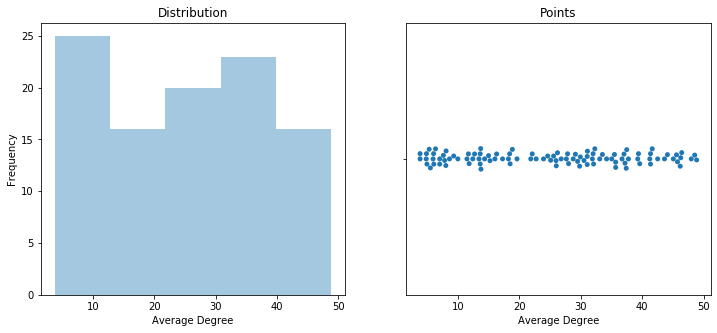

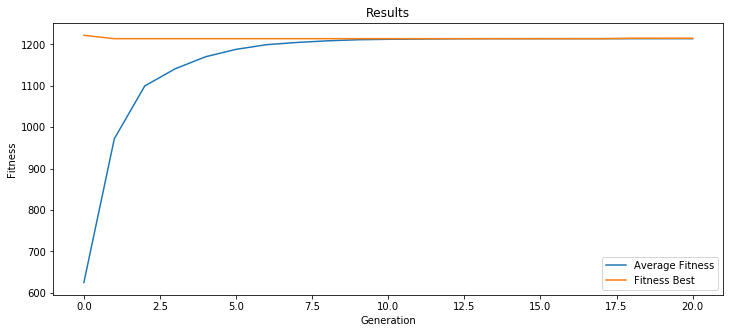

In [26]:
t1=time.time()
AG_1.run()
time.time()-t1